In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

In [3]:
df=pd.read_csv("/NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


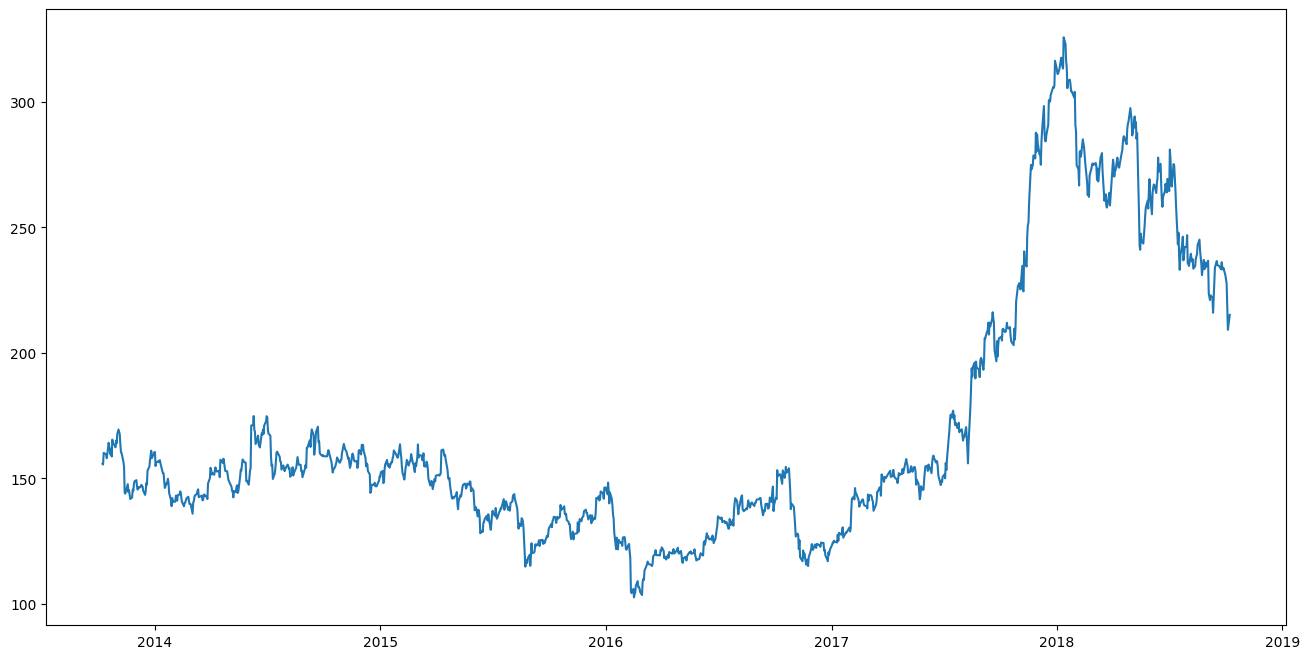

In [4]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [15]:
import pandas as pd

data = df.sort_index(ascending=True, axis=0)
new_dataset = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

# Use loc for proper assignment
for i in range(0, len(data)):
    new_dataset.loc[i, "Date"] = data.iloc[i]["Date"]
    new_dataset.loc[i, "Close"] = data.iloc[i]["Close"]


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Ensure Date column exists
print("Original columns in df:", df.columns)

# Sort data
data = df.sort_index(ascending=True, axis=0)

# Create DataFrame correctly
new_dataset = pd.DataFrame({
    "Date": data["Date"].values,   # Avoid NaN by using direct assignment
    "Close": data["Close"].values
})

# Set index before dropping 'Date'
new_dataset.set_index("Date", inplace=True)

# Ensure 'Close' column is numeric
new_dataset["Close"] = new_dataset["Close"].astype(float)

# Create final_dataset after fixing indexing
final_dataset = new_dataset.values  # This now contains only numerical data

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_dataset)

# Prepare training sequences
x_train_data, y_train_data = [], []

for i in range(60, len(final_dataset)):
    x_train_data.append(scaled_data[i-60:i, 0])
    y_train_data.append(scaled_data[i, 0])

# Convert to NumPy arrays
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# Reshape for LSTM input
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

print("Shape of x_train_data:", x_train_data.shape)
print("Shape of y_train_data:", y_train_data.shape)


Original columns in df: Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')
Shape of x_train_data: (1175, 60, 1)
Shape of y_train_data: (1175,)


In [19]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1175/1175 - 32s - 27ms/step - loss: 0.0030


In [20]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step


In [21]:
lstm_model.save("saved_model.h5")

In [22]:
from google.colab import files

files.download("saved_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-23-397e778e3e61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


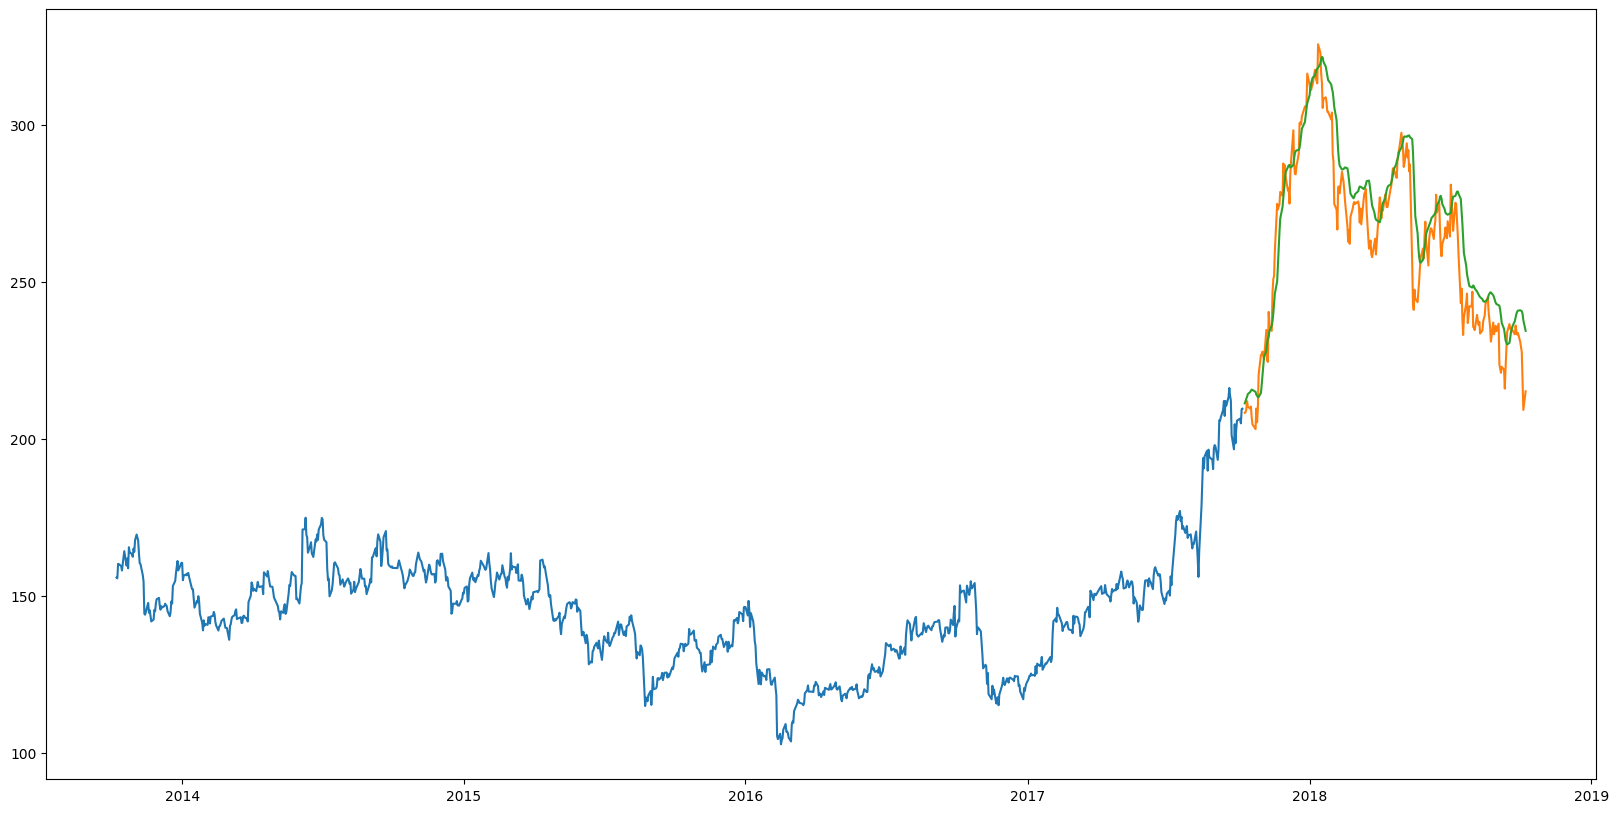

In [23]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])